<a href="https://colab.research.google.com/github/rkgupta7463/ML-projects-code/blob/main/Surface_Crack_Detection(final_year_project).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## How to use this project to in your colab notebook

Follow the steps:-

    1. Download Your Kaggle APIs Key and password file from your kaggle account in setting section
    2. Upload APIs key json file in your colab notebook and then run 3 cell of line which start from 2 upto 4 (these cell should only one time)



In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d arunrk7/surface-crack-detection

 97% 225M/233M [00:02<00:00, 109MB/s]
100% 233M/233M [00:02<00:00, 95.0MB/s]


In [3]:
import zipfile
zip = zipfile.ZipFile("/content/surface-crack-detection.zip",'r')
zip.extractall("/content/dataset")
zip.close()

In [4]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import Xception,VGG19,VGG16
from tensorflow.keras.layers import Input, Flatten, Dense,Dropout
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [5]:
# Define paths to your training and validation data directories
data_dir = "/content/dataset"

# Create data generator with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2  # Specify the validation split here
)

batch_size = 32
input_shape = (224, 224, 3)

# Load training data from the subdirectories and apply data augmentation
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42,
    subset="training"  # Specify the subset as "training"
)

# Load validation data from the same subdirectories (without data augmentation)
val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,  # No need to shuffle validation data
    seed=42,
    subset="validation"  # Specify the subset as "validation"
)

Found 32000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


In [6]:
train_generator.class_indices

{'Negative': 0, 'Positive': 1}

## **1. Model with CNN Architecture**

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
# Define the CNN model
model_cnn = Sequential()

# Convolutional layers
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))  # Input shape is adjusted to your image dimensions
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))

# Flatten layer to transition from convolutional to fully connected layers
model_cnn.add(Flatten())

# Fully connected layers
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(train_generator.num_classes, activation='sigmoid'))  # Binary classification, hence sigmoid activation

In [ ]:
# Compile the model
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Print the summary of the model
model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 26, 26, 128)      

In [ ]:
# Train the model
epochs = 5
history_cnn=model_cnn.fit(train_generator, epochs=epochs, validation_data=val_generator,batch_size=64)

Epoch 1/10
1000/1000 [==============================] - 479s 475ms/step - loss: 0.6977 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/10
1000/1000 [==============================] - 476s 476ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/10
1000/1000 [==============================] - 479s 479ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/10
1000/1000 [==============================] - 475s 475ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/10
1000/1000 [==============================] - 475s 475ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/10
1000/1000 [==============================] - 483s 483ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/10
1000/1000 [==============================] - 487s 487ms/step - loss: 0.6932 - accuracy: 0.5000 - val_

## 1. Xception model

In [7]:
# Load pretrained Xception model
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    pooling=None
)

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
flatten = Flatten()(base_model.output)
dense1 = Dense(512, activation="relu")(flatten)
output_layer = Dense(train_generator.num_classes, activation="sigmoid")(dense1)

# Create the Xception model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

# Print model summary
model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  

In [8]:
train_generator.num_classes

2

In [9]:
# Train the model
epochs = 5
history_1=model.fit(train_generator, epochs=epochs, validation_data=val_generator)

Epoch 1/5
1000/1000 [==============================] - 576s 566ms/step - loss: 0.1172 - accuracy: 0.9793 - val_loss: 0.0282 - val_accuracy: 0.9914
Epoch 2/5
1000/1000 [==============================] - 578s 578ms/step - loss: 0.0352 - accuracy: 0.9891 - val_loss: 0.0466 - val_accuracy: 0.9846
Epoch 3/5
1000/1000 [==============================] - 549s 549ms/step - loss: 0.0310 - accuracy: 0.9897 - val_loss: 0.0278 - val_accuracy: 0.9918
Epoch 4/5
1000/1000 [==============================] - 584s 584ms/step - loss: 0.0344 - accuracy: 0.9901 - val_loss: 0.0200 - val_accuracy: 0.9939
Epoch 5/5
1000/1000 [==============================] - 581s 581ms/step - loss: 0.0246 - accuracy: 0.9920 - val_loss: 0.0230 - val_accuracy: 0.9934


In [10]:
threshold=0.5
# Get true labels for validation data
val_true_labels = val_generator.classes
# Get predictions from the model
y_pred_xcp = model.predict(val_generator)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_xcp, axis=1)

250/250 [==============================] - 109s 431ms/step


In [11]:
##importing the evaluation metrics
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,confusion_matrix,classification_report

In [12]:
# Calculate accuracy
accuracy = accuracy_score(val_true_labels, y_pred_labels)
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))

Validation Accuracy: 99.39%


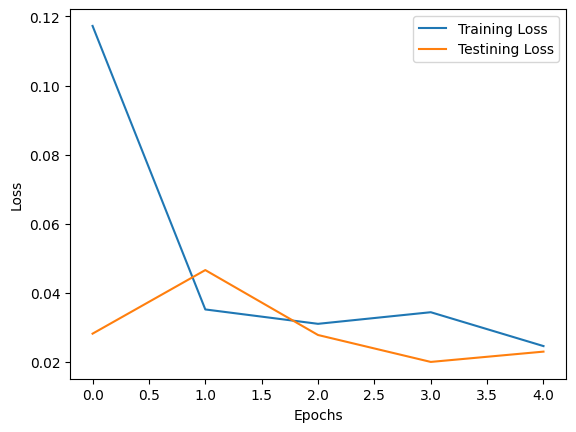

In [13]:
import matplotlib.pyplot as plt

plt.plot(history_1.history['loss'],label='Training Loss')
plt.plot(history_1.history['val_loss'],label='Testining Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

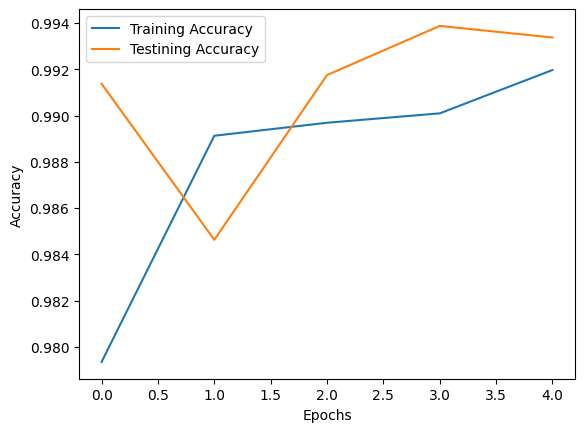

In [14]:
plt.plot(history_1.history['accuracy'],label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'],label='Testining Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

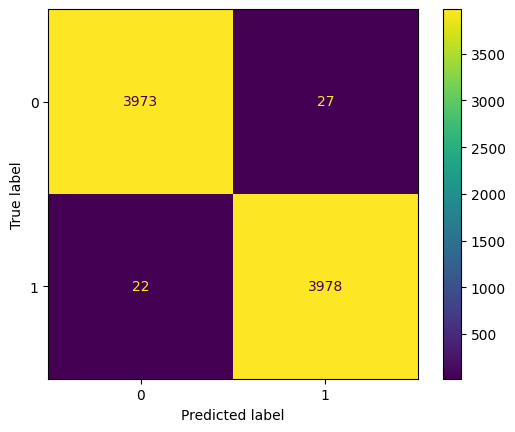

In [15]:
ConfusionMatrixDisplay(confusion_matrix(val_true_labels, y_pred_labels)).plot()

In [16]:
import cv2 as cv
import matplotlib.pyplot as plt
from keras.utils import img_to_array,array_to_img

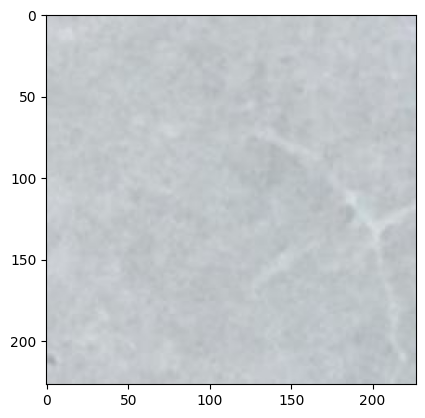

In [27]:
img=cv.imread('/content/dataset/Negative/00050.jpg')#('/content/dataset/Negative/00012.jpg')#('/content/dataset/Positive/00012.jpg')
plt.imshow(img)

In [28]:
sample_img = img_to_array(img)

# Resize the image to match the model's input shape (224, 224)
sample_img = cv.resize(sample_img, (224, 224))

# Normalize the pixel values to the range [0, 1]
sample_img = sample_img.astype(np.float32) / 255.0

# Reshape the image to a single-sample batch with the appropriate shape
sample_img = np.expand_dims(sample_img, axis=0)

# Now you can use the model to predict on the sample_img
predictions = model.predict(sample_img)
predictions

print("Predictions:", predictions)

1/1 [==============================] - 0s 26ms/step
Predictions: [[0.9705758  0.02541442]]


In [29]:
np.argmax(predictions)

0

In [26]:
model.save("surf_model_updated.h5")